In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
from transformers import AutoImageProcessor, EfficientNetModel
from chromadb.api.types import Documents, EmbeddingFunction, Embeddings
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import uuid
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

from sklearn.metrics.pairwise import cosine_similarity
import pickle
from pathlib import Path
import numpy as np
from tqdm import tqdm
from collections import OrderedDict
import concurrent
from basevectordb import BaseVectorDB

# import tensorflow as tf
# import compress_pickle
from chromadb import Client, PersistentClient

from chromadb.utils import embedding_functions
from chromadb.utils.data_loaders import ImageLoader
from chromadb.api.types import Documents, EmbeddingFunction, Embeddings
import os
import hashlib
from datetime import datetime
from typing import Dict, List, Tuple
from pathlib import Path
import json

/home/t/atest/reverse-image-search/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os


def plot_images_grid(image_paths, titles, grid_size=(2, 2)):

    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10))
    axes = axes.ravel()  # Flatten the axes array for easy iteration

    for i in range(len(image_paths)):
        img = mpimg.imread(image_paths[i])
        axes[i].imshow(img)
        axes[i].set_title(titles[i])
        axes[i].axis("off")  # Hide axes for better display

    # plt.tight_layout()
    plt.show()

In [3]:
from transformers import AutoModel

In [4]:
class EfficientNetEmbeddingFunction(EmbeddingFunction[Documents]):
    """To use this EmbeddingFunction, you must have the google.generativeai Python package installed and have a PaLM API key."""

    def __init__(self, model_name: str = "google/efficientnet-b0", device="cuda"):
        self.device = (
            "cuda" if torch.cuda.is_available() and device == "cuda" else "cpu"
        )
        self._model_name = model_name
        self.image_processor = AutoImageProcessor.from_pretrained(model_name)
        # self.model = EfficientNetModel.from_pretrained(model_name).to(self.device)
        self.model = AutoModel.from_pretrained(model_name).to(self.device)

    def load_image(self, image: str | Path | Image.Image | np.ndarray):
        """
        Loads an image and processes it using the model's image processor.
        Reusable helper function for single and batch image processing.
        """

        if isinstance(image, str) or isinstance(image, Path):
            image = Image.open(image)

        image = self.image_processor(images=image, return_tensors="pt").to(self.device)

        return image["pixel_values"]

    def _embed(self, pixel_values):
        """
        Helper function to perform model inference and return the embeddings.
        """
        with torch.no_grad():
            outputs = self.model(pixel_values=pixel_values)
        return outputs.pooler_output

    def embed_image(self, image):
        """
        Embeds a single image by first loading and processing it, then passing it to the model.
        """
        pixel_values = self.load_image(image)
        embeddings = self._embed(pixel_values)
        return embeddings.cpu().numpy().tolist()

    def batch_embed_images(
        self, images: list[str | Path | Image.Image | np.ndarray], batch_size: int = 32
    ):
        """
        Embeds a batch of images, processing them in batches of the specified batch_size.
        """
        all_embeddings = []

        for i in range(0, len(images), batch_size):
            batch = images[i : i + batch_size]
            processed_images = [self.load_image(image) for image in batch]
            batched_images = torch.cat(processed_images).to(self.device)
            batch_embeddings = self._embed(batched_images)
            all_embeddings.extend(batch_embeddings.cpu().numpy().tolist())

        return all_embeddings

    def __call__(
        self, images: list[Image.Image | Path | str], batch_size: int = 8
    ) -> Embeddings:
        return self.batch_embed_images(images, batch_size=batch_size)

In [5]:
import os
import hashlib
import uuid
from typing import Dict, List, Tuple
from pathlib import Path
import json
from chromadb import PersistentClient
from chromadb.utils.data_loaders import ImageLoader
from huggingface_hub import delete_collection

IMAGE_EXTENSIONS = (".jpg", ".jpeg", ".png", ".gif")  # keep it lower


class EmbeddingStore(BaseVectorDB):
    def __init__(
        self,
        save_dir: str | Path,
        embedding_model: EmbeddingFunction,
        collection_name: str = "my_collection",
        cache_file: str = "image_cache.json",
    ):
        self._save_dir = save_dir
        self.image_loader = ImageLoader()
        self.embedding_model = embedding_model
        self.collection_name = collection_name
        self.cache_file = Path(save_dir) / cache_file
        self.image_cache = self.load_cache()
        self.setup()

    def setup(self):
        self._client = PersistentClient(path=self._save_dir)
        self.collection = self._client.get_or_create_collection(
            name=self.collection_name,
            embedding_function=self.embedding_model,
            data_loader=self.image_loader,
        )

    def delete_collection(self):
        self._client.delete_collection(self.collection_name)

    def embed_images(self, image_paths: list[str], batch_size=16):
        embeddings = self.embedding_model.batch_embed_images(
            image_paths, batch_size=batch_size
        )
        return embeddings

    def load_cache(self) -> Dict[str, Dict[str, str | float]]:
        if self.cache_file.exists():
            with open(self.cache_file, "r") as f:
                return json.load(f)
        return {}

    def save_cache(self):
        with open(self.cache_file, "w") as f:
            json.dump(self.image_cache, f)

    def get_file_hash(self, file_path: str) -> str:
        with open(file_path, "rb") as f:
            file_hash = hashlib.md5()
            chunk = f.read(8192)
            while chunk:
                file_hash.update(chunk)
                chunk = f.read(8192)
        return file_hash.hexdigest()

    def update_images(
        self,
        image_paths: list[str | Path] = None,
        image_dir: str = None,
        batch_size: int = 16,
    ):

        if not image_paths:
            image_paths = [
                str(p)
                for p in Path(image_dir).glob("**/*")
                if p.suffix.lower() in IMAGE_EXTENSIONS
            ]

        new_images = []
        updated_images = []

        for image_path in image_paths:
            file_hash = self.get_file_hash(image_path)
            file_mtime = os.path.getmtime(image_path)

            if image_path not in self.image_cache:
                image_id = str(uuid.uuid4())
                new_images.append((image_id, image_path))
                self.image_cache[image_path] = {
                    "id": image_id,
                    "hash": file_hash,
                    "mtime": file_mtime,
                }
            elif (
                self.image_cache[image_path]["hash"] != file_hash
                or self.image_cache[image_path]["mtime"] != file_mtime
            ):
                image_id = self.image_cache[image_path]["id"]
                updated_images.append((image_id, image_path))
                self.image_cache[image_path]["hash"] = file_hash
                self.image_cache[image_path]["mtime"] = file_mtime

        if new_images:
            self.add_images(
                [path for _, path in new_images],
                [id for id, _ in new_images],
                batch_size=batch_size,
            )
            print(f"Added {len(new_images)} new images.")

        if updated_images:
            self.update_embeddings(
                [path for _, path in updated_images], [id for id, _ in updated_images]
            )
            print(f"Updated {len(updated_images)} existing images.")

        self.save_cache()

    def update_embeddings(self, image_paths: List[str | Path], image_ids: list[str]):
        embeddings = self.embed_images(image_paths)
        self.collection.update(ids=image_ids, uris=image_paths, embeddings=embeddings)

    def get_n_similar_images(self, image, k=5):
        return self.collection.query(
            query_uris=image,
            include=["uris", "distances", "metadatas", "embeddings", "documents"],
            n_results=k,
        )

    def add_images(
        self,
        image_paths: list[str] = None,
        image_dir: str | Path = None,
        image_ids: list[str] = None,
        **kwargs,
    ):

        if image_paths is None and os.path.isdir(image_dir):
            image_paths = [
                str(p)
                for p in Path(image_dir).glob("**/*")
                if p.suffix.lower() in IMAGE_EXTENSIONS
            ]

        self._add_images(image_paths, image_ids, **kwargs)

    def _add_images(
        self, image_paths: list[str], image_ids: list[str] = None, **kwargs
    ):
        batch_size = kwargs.pop("batch_size", 16)

        if image_ids is None:
            image_ids = [str(uuid.uuid4()) for _ in image_paths]

        embeddings = self.embed_images(image_paths, batch_size=batch_size)

        self.collection.add(
            ids=image_ids, uris=image_paths, embeddings=embeddings, **kwargs
        )

        for id, path in zip(image_ids, image_paths):
            file_hash = self.get_file_hash(path)
            file_mtime = os.path.getmtime(path)
            self.image_cache[path] = {"id": id, "hash": file_hash, "mtime": file_mtime}

        self.save_cache()

In [6]:
def plot_image(image_path):
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.show()

In [7]:
a = EfficientNetEmbeddingFunction()
# images = ["./sad-china.jpg", "animal.jpg", "face.jpg"]

In [8]:
import random

In [9]:
image_dir = Path("./samples")

In [10]:
images = [str(i.absolute()) for i in image_dir.glob("*.jpg")]
len(images), images[:10]

(255,
 ['/home/t/atest/reverse-image-search/v2/samples/IMG-20240522-WA0002.jpg',
  '/home/t/atest/reverse-image-search/v2/samples/IMG_20230802_203805.jpg',
  '/home/t/atest/reverse-image-search/v2/samples/IMG_20231025_202427.jpg',
  '/home/t/atest/reverse-image-search/v2/samples/IMG-20240101-WA0000.jpg',
  '/home/t/atest/reverse-image-search/v2/samples/baba adhaar card, adhar IMG-20240203-WA0005.jpg',
  '/home/t/atest/reverse-image-search/v2/samples/IMG_20240428_181918.jpg',
  '/home/t/atest/reverse-image-search/v2/samples/IMG_20240122_105414.jpg',
  '/home/t/atest/reverse-image-search/v2/samples/887f3d00890e4873b1dfc8ef2e56f5f9.jpg',
  '/home/t/atest/reverse-image-search/v2/samples/IMG_20240603_153037.jpg',
  '/home/t/atest/reverse-image-search/v2/samples/IMG_20240508_120237.jpg'])

In [11]:
# aa = a(images)
# len(aa[0]), len(aa)

In [12]:
# from vec import EmbeddingStore
# from embed_model import EfficientNetEmbeddingFunction

embedding_model = a
# images = ['sad-china.jpg', 'animal.jpg', 'face.jpg']
db = EmbeddingStore("test", embedding_model)

db.setup()

In [13]:
db.add_images(images)

In [17]:
os.getcwd()

'/home/t/atest/reverse-image-search/v2'

In [19]:
new_folder = "./mores"

In [18]:
db.update_images(new_folder)

Added 370 new images.


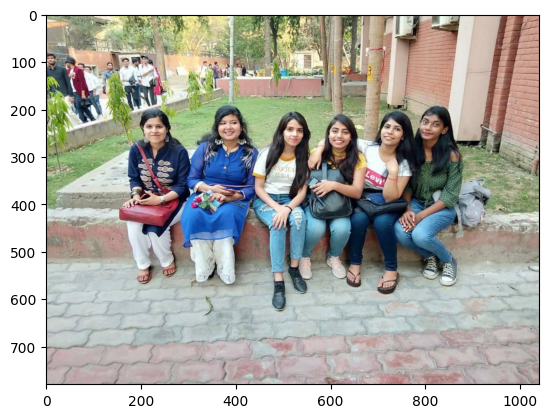

In [34]:
selected_image = random.choice(list(Path(new_folder).iterdir()))
plot_image(selected_image)

In [35]:
out = db.get_n_similar_images(str(selected_image.absolute()), k=12)
sim_files = out["uris"][0]
dists = out["distances"][0]
# sim_files, dists

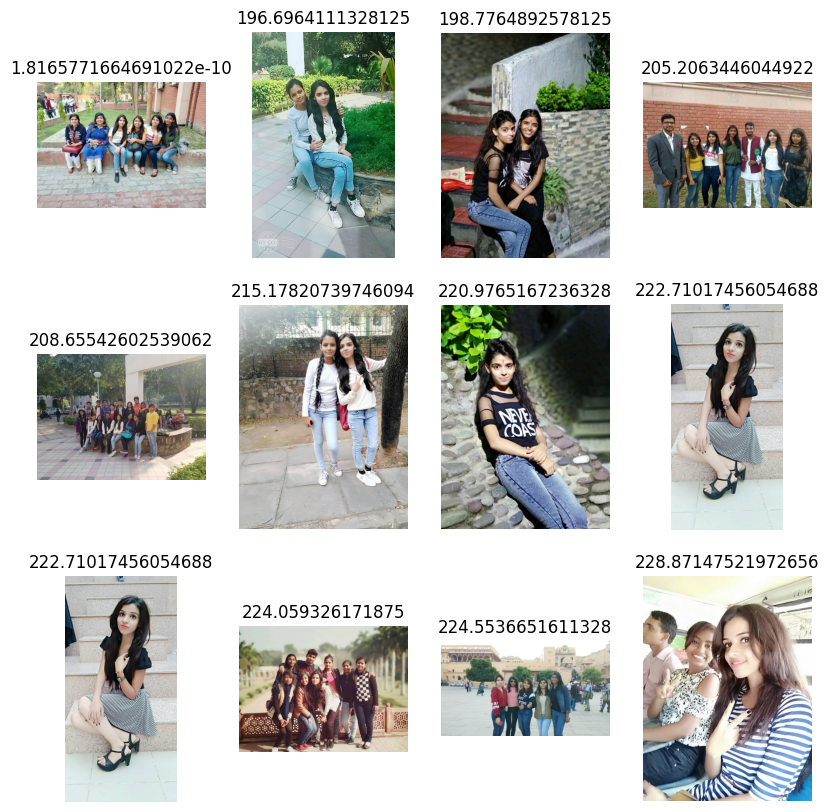

In [36]:
plot_images_grid(sim_files, titles=dists, grid_size=[3, 4])